# 1. Importing Libraries and Data

In [1]:
# Most common libraries for functionality
import pandas as pd
import os
os.chdir(os.path.dirname(os.getcwd()))
import numpy as np
from datetime import datetime,date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2
import pickle as pkl

In [2]:
# TSA Libraries
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from tbats import TBATS, BATS
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools

In [ ]:
# Own libraries 
from src.data import preprocessing


In [1]:
# ML libraries
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

# Forecasting the demand

In [4]:
path_demand = '\\data\\raw\\ExitZoneAllocation.xlsx'
raw_demand = os.getcwd() + path_demand

gas_demand = pd.read_excel(raw_demand)

In [5]:
gas_demand = gas_demand.groupby(['Time'])['Data'].sum()


In [6]:
gas_demand.index = pd.to_datetime(gas_demand.index, format='%d-%m-%Y')

gas_demand.index = pd.DatetimeIndex(gas_demand.index.values, freq=gas_demand.index.inferred_freq)


In [7]:
gas_demand = gas_demand.sort_index()

In [8]:
gas_demand.loc['2018'].index#.plot()

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=365, freq=None)

In [9]:
gas_demand = gas_demand/1000


In [10]:
gas_demand.head()

2012-01-01    3613.082
2012-01-02    4787.492
2012-01-03    5091.137
2012-01-04    5230.142
2012-01-05    5403.952
Name: Data, dtype: float64

In [11]:
gas_demand.loc['2018'].sum()

1190278.273

Text(0, 0.5, 'Daily gas demand in Denmark [MWh]')

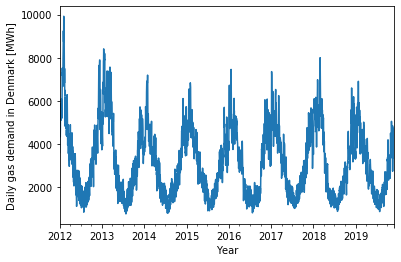

In [12]:
gas_demand.plot()
plt.xlabel('Year')
plt.ylabel('Daily gas demand in Denmark [MWh]')

Text(0, 0.5, 'Daily gas demand in Denmark [MWh]')

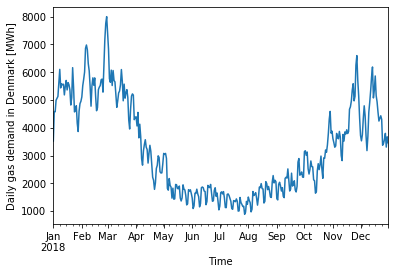

In [13]:
gas_demand.loc['2018'].plot()
plt.xlabel('Time')
plt.ylabel('Daily gas demand in Denmark [MWh]')

## Prophet

In [15]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [18]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(mean.shape[0]), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)

### Holidays

In [19]:
from datetime import date
import holidays

In [20]:
dk_holidays = holidays.Denmark()

In [21]:
holidays_analysed = []
for year in range(2012,2020):
    for date, name in sorted(holidays.DK(years=year).items()):
        holidays_analysed.append((date, name))

In [22]:
holidays_analysed = pd.DataFrame(holidays_analysed)
holidays_analysed.columns = ['ds', 'holiday']
holidays_analysed

,ds,holiday
0,2012-01-01,Nytårsdag
1,2012-04-01,Palmesøndag
2,2012-04-05,Skærtorsdag
3,2012-04-06,Langfredag
4,2012-04-08,Påskedag
...,...,...
91,2019-05-30,Kristi himmelfartsdag
92,2019-06-09,Pinsedag
93,2019-06-10,Anden pinsedag
94,2019-12-25,Juledag


In [23]:
holidays_analysed.holiday.unique()

array(['Nytårsdag', 'Palmesøndag', 'Skærtorsdag', 'Langfredag',
       'Påskedag', 'Anden påskedag', 'Store bededag',
       'Kristi himmelfartsdag', 'Pinsedag', 'Anden pinsedag', 'Juledag',
       'Anden juledag'], dtype=object)

### Preprocessing

In [24]:
# Prophet needs preprocessing - there have to be 2 columns, 'ds' and 'y'
gas_demand_prophet = pd.DataFrame(gas_demand)
gas_demand_prophet['Time'] = gas_demand_prophet.index
gas_demand_prophet = gas_demand_prophet.reset_index()
gas_demand_prophet = gas_demand_prophet.loc[:,['Data','Time']]
gas_demand_prophet.columns = ['y', 'ds']
gas_demand_prophet.head()

,y,ds
0,3613.082,2012-01-01
1,4787.492,2012-01-02
2,5091.137,2012-01-03
3,5230.142,2012-01-04
4,5403.952,2012-01-05


In [25]:
data_since = '2012-01-01'
data_till = '2016-06-30'
forecasting_since = '2016-07-01'
forecasting_till = '2017-04-30'
two_years_before = '2014-07-01'

In [26]:
# Creating training dataset
train_df = gas_demand_prophet[(gas_demand_prophet['ds'] >= data_since) & (gas_demand_prophet['ds'] <= data_till)]
test_dt = gas_demand_prophet[(gas_demand_prophet['ds'] >= forecasting_since) & (gas_demand_prophet['ds'] <= forecasting_till)]


### Modelling

In [27]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, growth='linear', holidays=holidays_analysed)
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
model_fit = m.make_future_dataframe(periods = ((pd.to_datetime(forecasting_till) - pd.to_datetime(forecasting_since)).days + 1))
test_y = m.predict(model_fit)

In [29]:
y_true = gas_demand.loc[forecasting_since:forecasting_till]

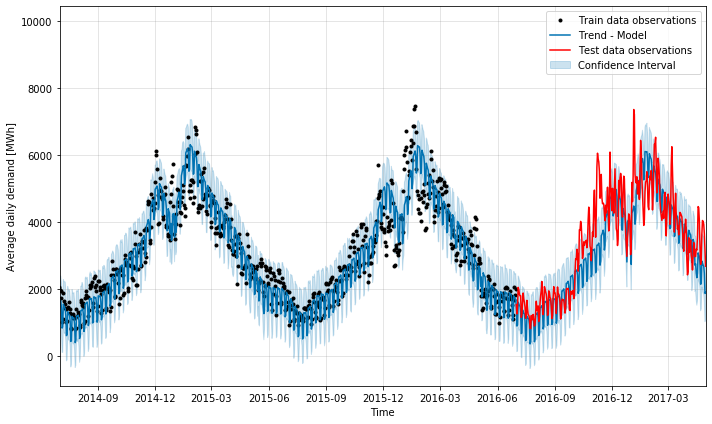

In [30]:
m.plot(test_y)
plt.plot(y_true, color = 'red')
plt.ylabel('Average daily demand [MWh]')
plt.xlabel('Time')
plt.xlim((pd.to_datetime(two_years_before), pd.to_datetime(forecasting_till)))
plt.legend(['Train data observations', 'Trend - Model', 'Test data observations', 'Confidence Interval'])


In [31]:
print('MAE =', mean_absolute_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('MAPE =', mean_absolute_percentage_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('RMSE =', mean_squared_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)], squared = False))


MAE = 558.0027005439098
MAPE = 0.16757617690471568
RMSE = 756.6033370444768


In [165]:
print('MAE =', mean_absolute_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('R2 =', r2_score(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('MedAE =', median_absolute_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('MSE =', mean_squared_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))
print('MSLE =', mean_squared_log_error(y_true, test_y['yhat'][(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)]))


MAE = 838.0065767488543
R2 = 0.5466578503405457
MedAE = 717.2660709860124
MSE = 926440.0523357711
MSLE = 0.09772165718493553


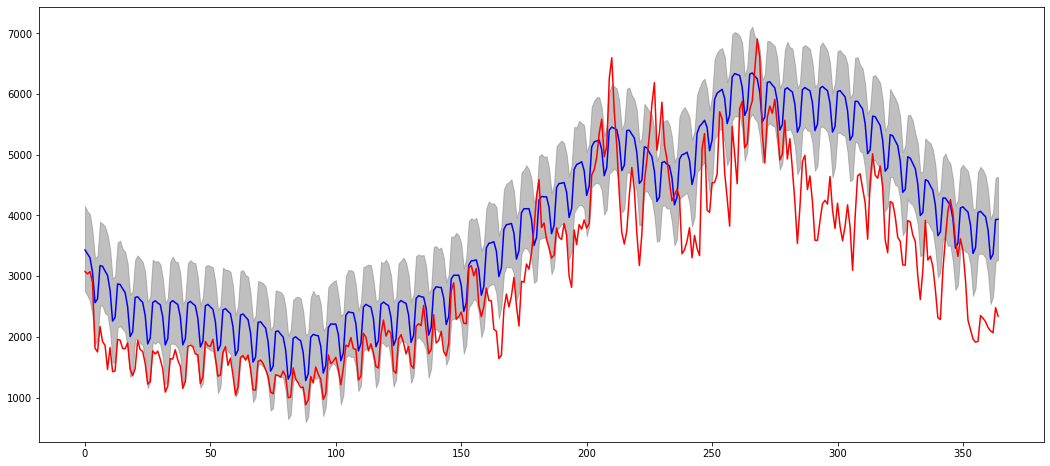

In [166]:
y_pred = test_y[(test_y['ds'] >= forecasting_since) & (test_y['ds'] <= forecasting_till)].reset_index()
plot_mean_and_CI(y_pred['yhat'], y_pred['yhat_lower'], y_pred['yhat_upper'], color_mean = 'blue', color_shading = 'grey')
plt.plot(gas_demand.loc[forecasting_since:forecasting_till].values, color = 'red')


## Weekly results analysis

In [18]:
weekly_gas_demand = pd.DataFrame(gas_demand)
weekly_gas_demand['Time'] = weekly_gas_demand.index

In [19]:
gas_demand.tail()

2019-11-27    4114.640
2019-11-28    4057.903
2019-11-29    4680.526
2019-11-30    4655.325
2019-12-01    4771.638
Name: Data, dtype: float64

In [20]:
weekly_gas_demand.tail()

,Data,Time
2019-11-27,4114.640,2019-11-27
2019-11-28,4057.903,2019-11-28
2019-11-29,4680.526,2019-11-29
2019-11-30,4655.325,2019-11-30
2019-12-01,4771.638,2019-12-01


In [22]:
weekly_gas_demand = weekly_gas_demand.resample('W-Mon', on='Time')['Data'].mean()

In [23]:
weekly_gas_demand.loc['2013':'2018']

Time
2013-01-07    4398.350000
2013-01-14    6243.061429
2013-01-21    7730.429571
2013-01-28    7300.678857
2013-02-04    5481.476286
                 ...     
2018-12-03    4686.743286
2018-12-10    4098.324857
2018-12-17    5508.408857
2018-12-24    4565.772714
2018-12-31    3516.346429
Freq: W-MON, Name: Data, Length: 313, dtype: float64

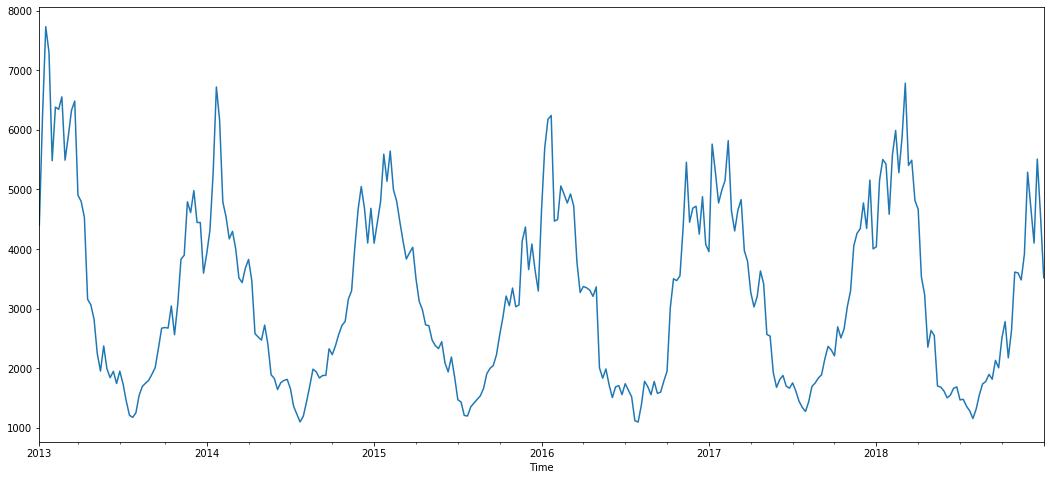

In [24]:
weekly_gas_demand.loc['2013':'2018'].plot()

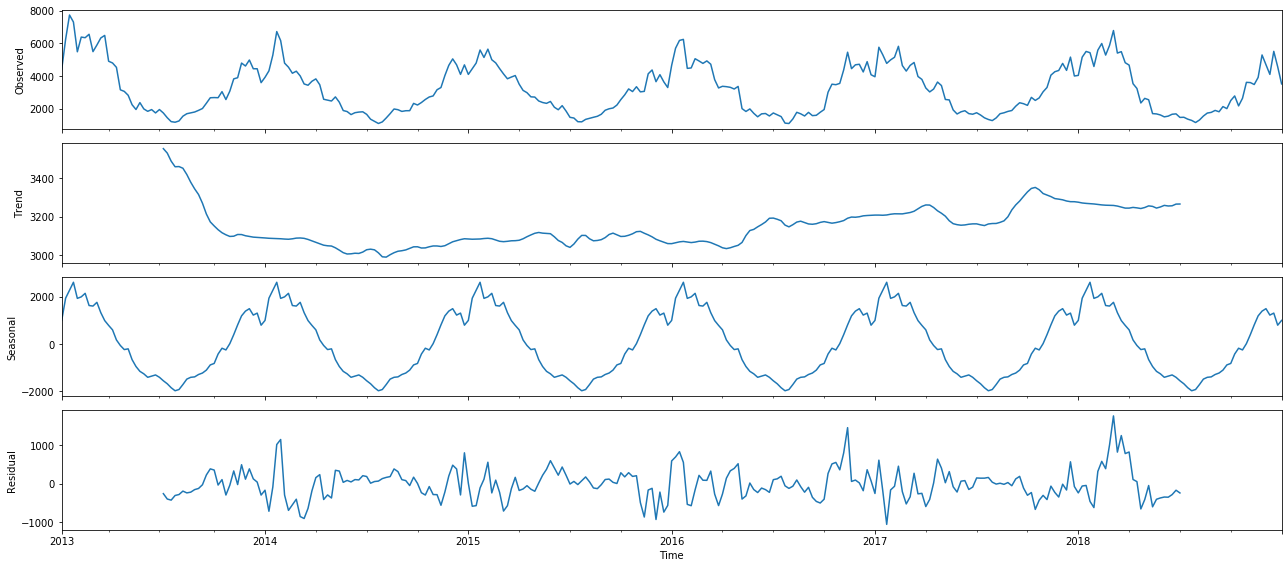

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_yearly = sm.tsa.seasonal_decompose(weekly_gas_demand.loc['2013':'2018'], model='additive')
fig = decomposition_yearly.plot()
plt.show()

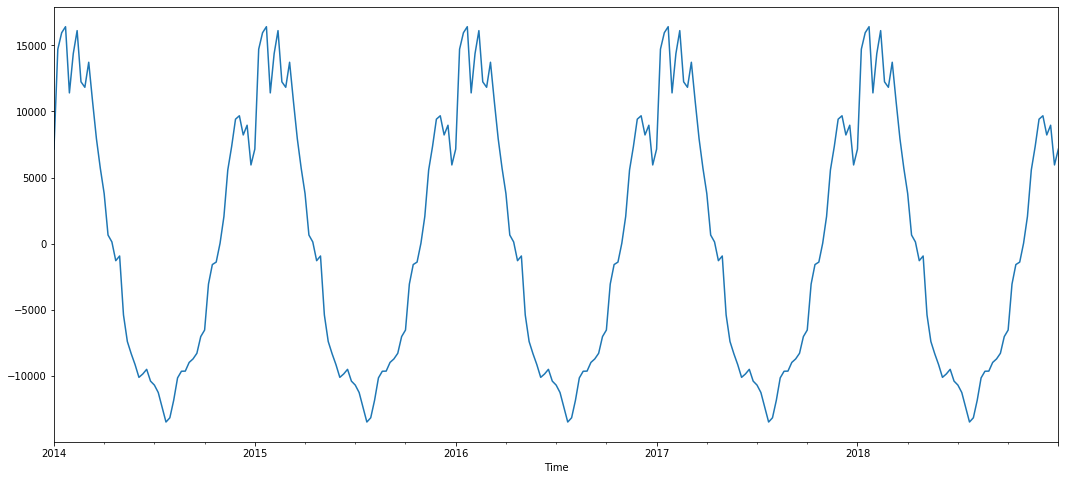

In [61]:
decomposition_yearly.seasonal.loc['2014':'2018'].plot()

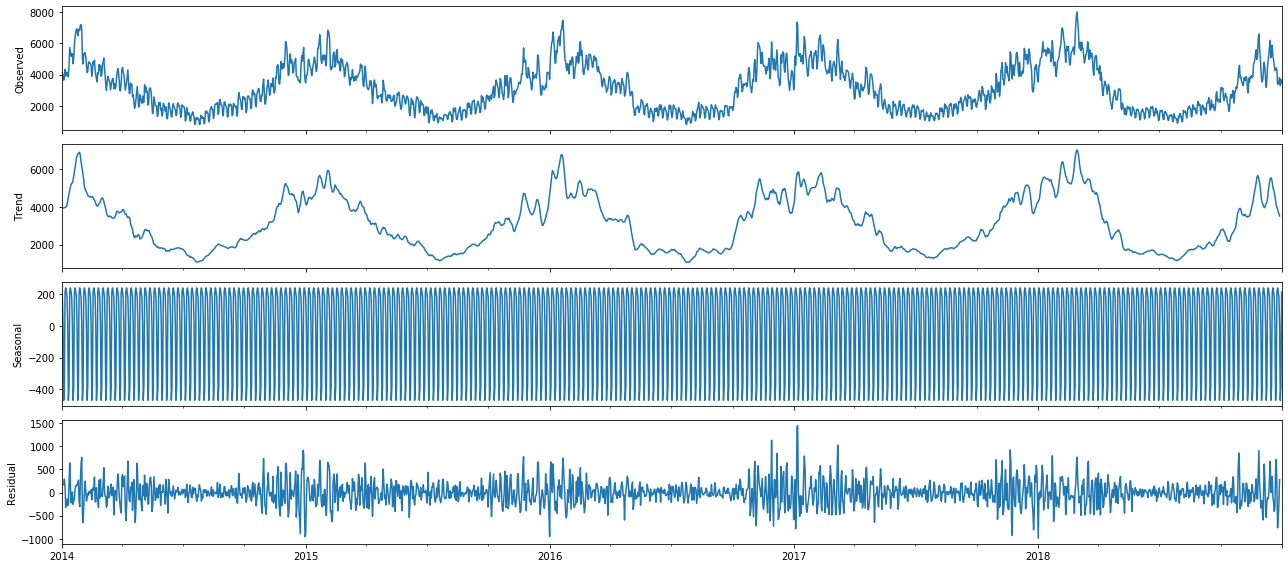

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition_weekly = sm.tsa.seasonal_decompose(gas_demand.loc['2014':'2018'], model='additive')
fig = decomposition_weekly.plot()
plt.show()

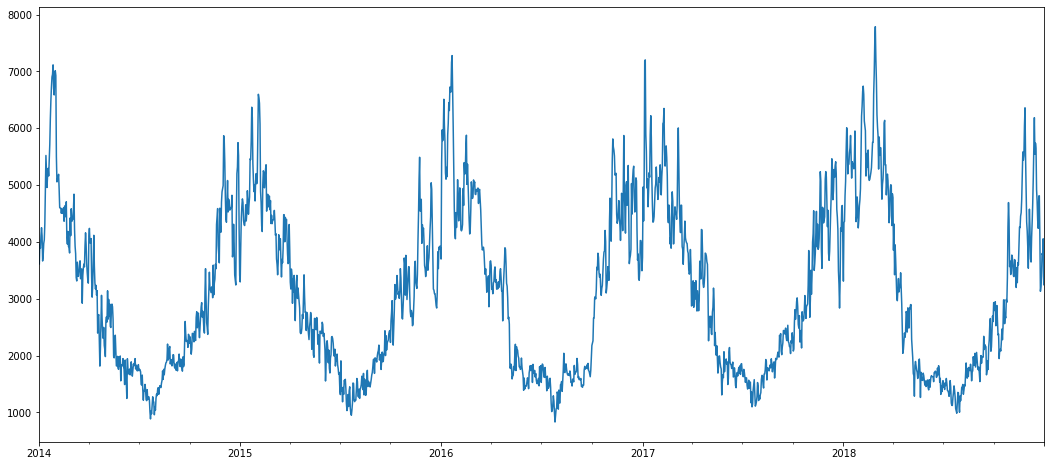

In [64]:
(decomposition_weekly.observed - decomposition_weekly.seasonal).plot()

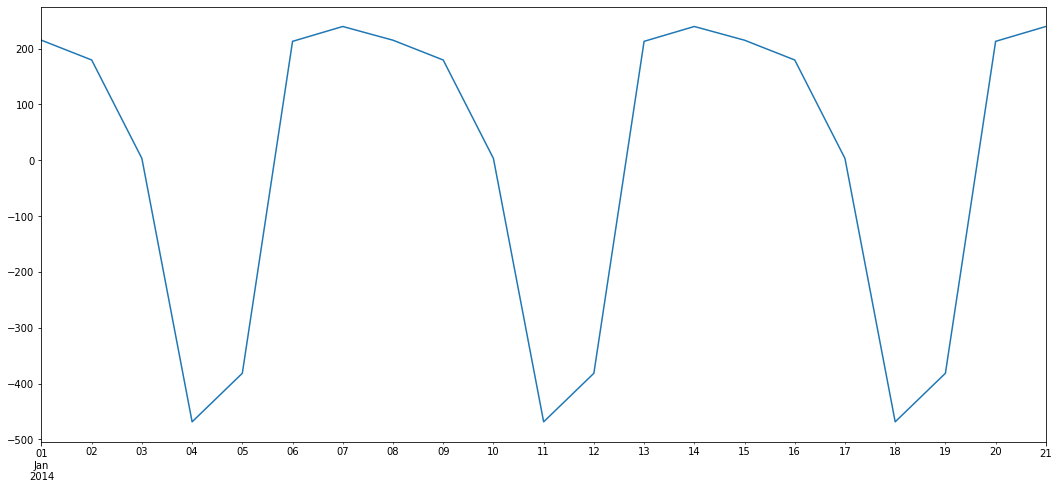

In [65]:
decomposition_weekly.seasonal.iloc[:21].plot()

In [66]:
decomposition_weekly.seasonal

2014-01-01    214.905193
2014-01-02    179.481543
2014-01-03      3.167170
2014-01-04   -468.442636
2014-01-05   -381.468053
                 ...    
2018-12-27    179.481543
2018-12-28      3.167170
2018-12-29   -468.442636
2018-12-30   -381.468053
2018-12-31    212.879320
Name: Data, Length: 1826, dtype: float64

In [67]:
decomposition_yearly.seasonal

Time
2014-01-06     7152.473026
2014-01-13    14702.958824
2014-01-20    15948.052292
2014-01-27    16405.474357
2014-02-03    11400.357893
                  ...     
2018-12-03     9671.688660
2018-12-10     8221.537285
2018-12-17     8955.888533
2018-12-24     5953.634877
2018-12-31     7152.473026
Freq: W-MON, Name: Data, Length: 261, dtype: float64

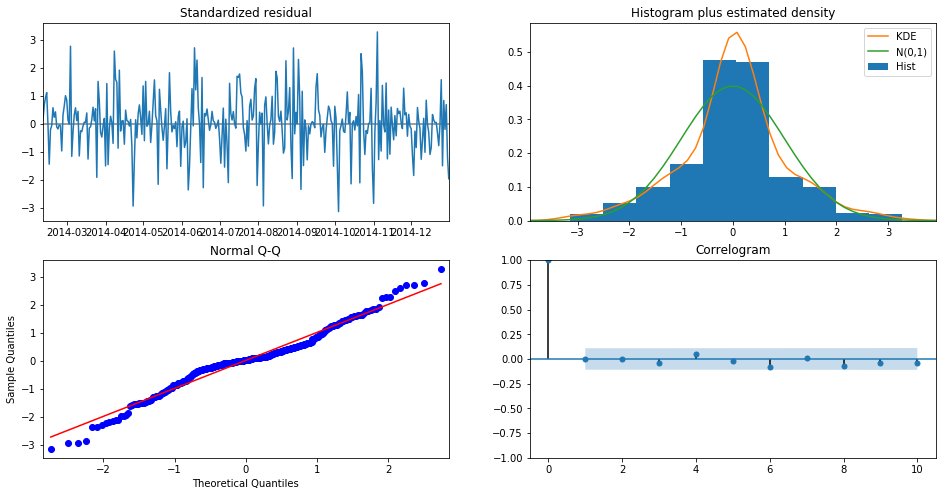

In [23]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

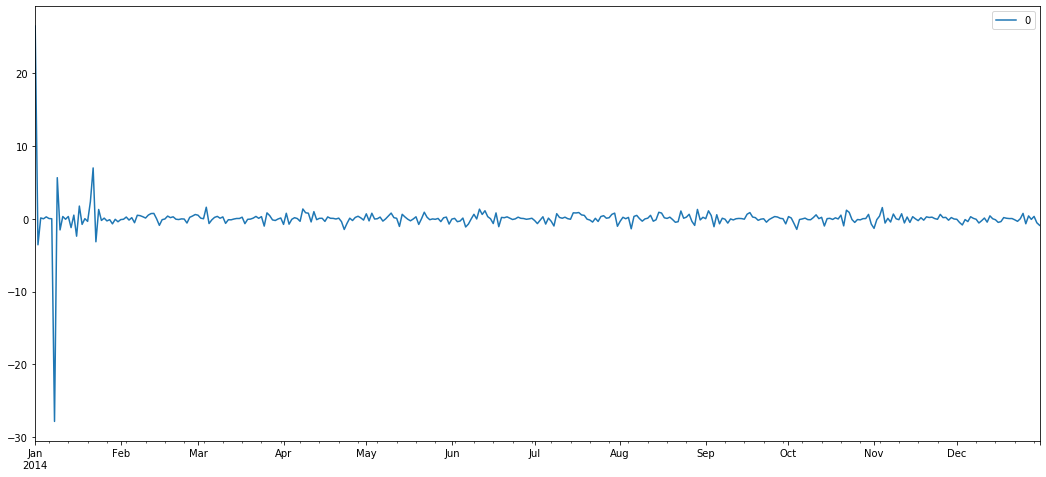

In [24]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

                0
count  365.000000
mean     0.018496
std      2.146262
min    -27.836775
25%     -0.192603
50%      0.007395
75%      0.242021
max     26.440000


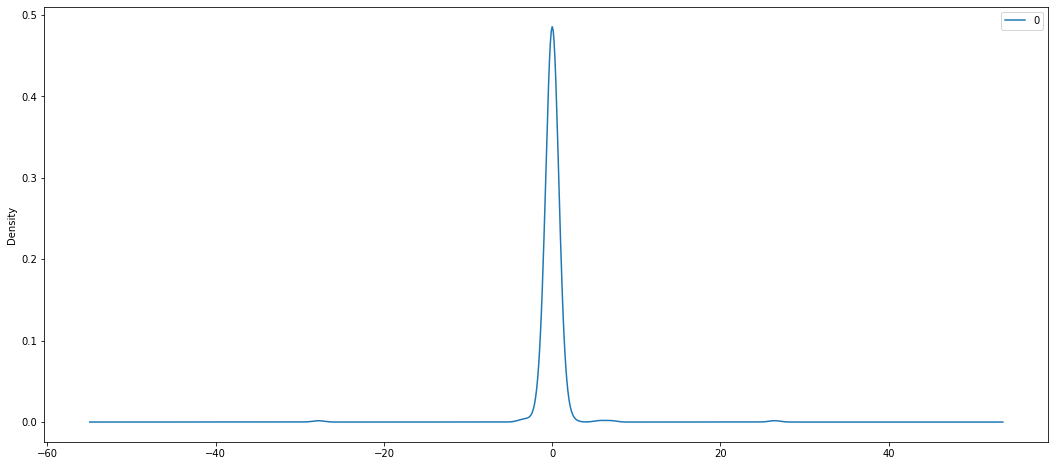

In [25]:
# density plot of the residual error values
residuals.plot(kind='kde')
print(residuals.describe())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


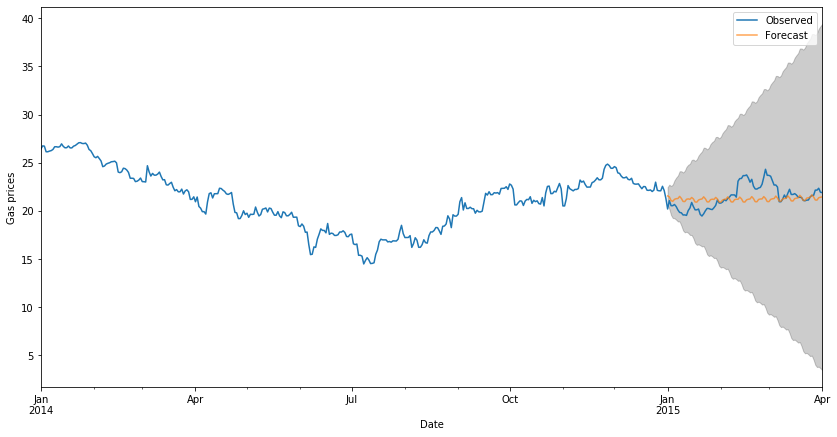

In [26]:
pred = model_fit.get_prediction(start=forecasting_since, end=forecasting_till, dynamic=False)
pred_ci = pred.conf_int()
ax = market_data[data_since:forecasting_till].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Gas prices')
plt.legend()
plt.show()

In [27]:
y_forecasted = pred.predicted_mean
y_truth = market_data['2013-01-01':'2013-04-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is nan
The Root Mean Squared Error of our forecasts is nan
